In [ ]:
!svn checkout https://github.com/FSMVU-Tubitak-1001-Kod-Analiz/Code_Similarity.git

/bin/bash: line 1: svn: command not found


In [1]:
# prompt: clone github repo and upload the files on google collab

!git clone https://github.com/FSMVU-Tubitak-1001-Kod-Analiz/Code_Similarity.git
%cd Code_Similarity
!ls


Cloning into 'Code_Similarity'...
remote: Enumerating objects: 1043, done.
remote: Counting objects: 100% (1040/1040), done.
remote: Compressing objects: 100% (235/235), done.
remote: Total 1043 (delta 385), reused 1000 (delta 349), pack-reused 3
Receiving objects: 100% (1043/1043), 120.30 KiB | 1.16 MiB/s, done.
Resolving deltas: 100% (385/385), done.
/content/Code_Similarity
'Dataset Triploss'   tripletloss.py   TripletLoss.py


In [4]:
import os
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
import numpy as np
# Define the directory where the 'Dataset' folder is located
base_path = r'/content/Code_Similarity/Dataset Triploss'

# Arrays to hold the file paths
positive_array = []  # To store paths of 'plagiarized' files
anchor_array = []    # To store paths of 'original' files
negative_array = []  # To store paths of 'non-plagiarized' files

# Walk through the directory structure
for root, dirs, files in os.walk(base_path):
    for file in files:
        # Construct the full file path
        file_path = os.path.join(root, file)
        # Categorize the files based on the containing directory
        if 'plagiarized' in root:
            positive_array.append(file_path)
        if 'original' in root:
            anchor_array.append(file_path)
        if 'negative' in root:
            negative_array.append(file_path)


In [5]:
positive_array[0],anchor_array[0],negative_array[0]

('/content/Code_Similarity/Dataset Triploss/case-01/plagiarized/L2/03/WelcomeToJava.java',
 '/content/Code_Similarity/Dataset Triploss/case-01/original/T1.java',
 '/content/Code_Similarity/Dataset Triploss/case-01/negative/09/t01.java')

In [6]:
# Gerekli Kütüphaneler
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
import os

# CodeBERT Tokenizer ve Modelini Yükle
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
codebert_model = TFAutoModel.from_pretrained("microsoft/codebert-base")

# Kodu tokenize etme fonksiyonu
def tokenize_code(file_path, tokenizer):
    with open(file_path, 'r', encoding='utf-8') as file:
        code = file.read()
    inputs = tokenizer(code, return_tensors="tf", truncation=True, padding='max_length', max_length=512)
    return inputs['input_ids'], inputs['attention_mask']

# Dosyaları işleyip tokenize etme fonksiyonu
def load_and_tokenize_data(file_paths, tokenizer):
    input_ids_list = []
    attention_masks_list = []
    for path in file_paths:
        input_ids, attention_mask = tokenize_code(path, tokenizer)
        input_ids_list.append(tf.squeeze(input_ids))
        attention_masks_list.append(tf.squeeze(attention_mask))
    return input_ids_list, attention_masks_list

# Gömme Modelini Tanımla
def codebert_embedding_model():
    input_ids = tf.keras.layers.Input(shape=(512,), dtype='int32')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype='int32')
    embeddings = codebert_model(input_ids, attention_mask=attention_mask)[0][:,0,:]
    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=embeddings)

embedding_model = codebert_embedding_model()

# Triplet Loss Fonksiyonu

'''
Bu fonksiyon, modelin anchor ile positive arasındaki mesafeyi azaltıp,
 anchor ile negative arasındaki mesafeyi artırmasını sağlayacak şekilde kaybı (loss) hesaplar.
'''
def triplet_loss(y_true, y_pred, alpha=0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)  # Anchor ile Positive arasındaki mesafe
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)  # Anchor ile Negative arasındaki mesafe
    basic_loss = pos_dist - neg_dist + alpha  # Loss hesaplama
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0))  # Loss'un sıfırdan büyük olmasını sağlama
    return loss


# Veri setlerini yükle ve tokenize et
anchor_input_ids, anchor_attention_masks = load_and_tokenize_data(anchor_array, tokenizer)
positive_input_ids, positive_attention_masks = load_and_tokenize_data(positive_array, tokenizer)
negative_input_ids, negative_attention_masks = load_and_tokenize_data(negative_array, tokenizer)

# Veri setini oluştur
def create_dataset(input_ids, attention_masks):
    return tf.data.Dataset.from_tensor_slices((input_ids, attention_masks))

anchor_dataset = create_dataset(anchor_input_ids, anchor_attention_masks)
positive_dataset = create_dataset(positive_input_ids, positive_attention_masks)
negative_dataset = create_dataset(negative_input_ids, negative_attention_masks)

triplet_dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
batch_size = 32  # Batch boyutunu ayarla
triplet_dataset = triplet_dataset.batch(batch_size)

# Eğitim döngüsü
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
# Toplam eğitim epoch sayısını ayarla
num_epochs = 10

'''
Yukarıda verilen kod, bir Triplet Loss modelinin eğitimini ve modelin bir dosya olarak saklanmasını sağlar.
Eğitim sürecinde, model "code_similarity_model" adı altında yerel diskte kaydedilir.
Bu, modelin eğitim sonrası durumunu içerir ve bu modeli daha sonra kullanmak için bu dosyayı yükleyebilirsiniz.

'''
# Eğitim epoch'ları için döngü
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} başlıyor")  # Mevcut epoch'un başladığını bildir
    epoch_loss = 0  # Bu epoch için toplam kaybı sıfırla

    # Dataset üzerinden döngü yaparak her bir triplet için eğitim gerçekleştir
    for step, ((anchor_input, anchor_mask), (positive_input, positive_mask), (negative_input, negative_mask)) in enumerate(triplet_dataset):

        '''
        tf.GradientTape kullanımının nedeni, TensorFlow'da otomatik türev hesaplama işlevini sağlamasıdır.
        Derin öğrenme modelleri genellikle geri yayılım (backpropagation) yoluyla eğitilir,
        bu süreçte modelin ağırlıkları, kayıp fonksiyonunun (loss function) gradyanlarına göre güncellenir.
         tf.GradientTape bu gradyan hesaplamalarını kolaylaştırır.
        '''
        with tf.GradientTape() as tape:
            # Embedding modelini kullanarak anchor, positive ve negative için embedding'leri hesapla
            anchor_embeddings = embedding_model([anchor_input, anchor_mask])
            positive_embeddings = embedding_model([positive_input, positive_mask])
            negative_embeddings = embedding_model([negative_input, negative_mask])

            # Triplet kaybını hesapla
            loss = triplet_loss(None, [anchor_embeddings, positive_embeddings, negative_embeddings])

        # Hesaplanan kayıp üzerinden gradyanları hesapla
        gradients = tape.gradient(loss, embedding_model.trainable_variables)
        # Optimizer kullanarak gradyanları uygula ve model ağırlıklarını güncelle
        optimizer.apply_gradients(zip(gradients, embedding_model.trainable_variables))
        # Epoch kaybına bu adımdaki kaybı ekle
        epoch_loss += loss.numpy()

    # Epoch sonunda toplam kaybı yazdır
    print(f"Epoch {epoch+1} Kaybı: {epoch_loss}")


# Modeli kaydet
embedding_model.save("code_similarity_model")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tf_model.h5:   0%|          | 0.00/499M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at microsoft/codebert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1 başlıyor


Epoch 1 Kaybı: 2.8345837593078613
Epoch 2 başlıyor


Epoch 2 Kaybı: 0.8000562787055969
Epoch 3 başlıyor


Epoch 3 Kaybı: 0.03425123915076256
Epoch 4 başlıyor


Epoch 4 Kaybı: 0.0
Epoch 5 başlıyor


Epoch 5 Kaybı: 0.0
Epoch 6 başlıyor


Epoch 6 Kaybı: 0.0
Epoch 7 başlıyor


Epoch 7 Kaybı: 0.0
Epoch 8 başlıyor


Epoch 8 Kaybı: 0.0
Epoch 9 başlıyor


Epoch 9 Kaybı: 0.0
Epoch 10 başlıyor


Epoch 10 Kaybı: 0.0


In [7]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

# Load CodeBERT Model
codebert_model = TFAutoModel.from_pretrained("microsoft/codebert-base")

# Rebuild the embedding model architecture (matching the saved model)
def codebert_embedding_model():
    input_ids = tf.keras.layers.Input(shape=(512,), dtype='int32')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype='int32')
    embeddings = codebert_model(input_ids, attention_mask=attention_mask)[0][:,0,:]
    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=embeddings)

# Instantiate the model
embedding_model = codebert_embedding_model()

# Load the weights from the saved model
embedding_model.load_weights("code_similarity_model")
# Triplet Loss Fonksiyonu

'''
Bu fonksiyon, modelin anchor ile positive arasındaki mesafeyi azaltıp,
 anchor ile negative arasındaki mesafeyi artırmasını sağlayacak şekilde kaybı (loss) hesaplar.
'''
def triplet_loss(y_true, y_pred, alpha=0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)  # Anchor ile Positive arasındaki mesafe
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)  # Anchor ile Negative arasındaki mesafe
    basic_loss = pos_dist - neg_dist + alpha  # Loss hesaplama
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0))  # Loss'un sıfırdan büyük olmasını sağlama
    return loss


# Veri setlerini yükle ve tokenize et
anchor_input_ids, anchor_attention_masks = load_and_tokenize_data(anchor_array, tokenizer)
positive_input_ids, positive_attention_masks = load_and_tokenize_data(positive_array, tokenizer)
negative_input_ids, negative_attention_masks = load_and_tokenize_data(negative_array, tokenizer)

# Veri setini oluştur
def create_dataset(input_ids, attention_masks):
    return tf.data.Dataset.from_tensor_slices((input_ids, attention_masks))

anchor_dataset = create_dataset(anchor_input_ids, anchor_attention_masks)
positive_dataset = create_dataset(positive_input_ids, positive_attention_masks)
negative_dataset = create_dataset(negative_input_ids, negative_attention_masks)

triplet_dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
batch_size = 32  # Batch boyutunu ayarla
triplet_dataset = triplet_dataset.batch(batch_size)

# Eğitim döngüsü
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
# Toplam eğitim epoch sayısını ayarla
num_epochs = 10

# Eğitim epoch'ları için döngü
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} başlıyor")  # Mevcut epoch'un başladığını bildir
    epoch_loss = 0  # Bu epoch için toplam kaybı sıfırla

    # Dataset üzerinden döngü yaparak her bir triplet için eğitim gerçekleştir
    for step, ((anchor_input, anchor_mask), (positive_input, positive_mask), (negative_input, negative_mask)) in enumerate(triplet_dataset):

        with tf.GradientTape() as tape:
            # Embedding modelini kullanarak anchor, positive ve negative için embedding'leri hesapla
            anchor_embeddings = embedding_model([anchor_input, anchor_mask])
            positive_embeddings = embedding_model([positive_input, positive_mask])
            negative_embeddings = embedding_model([negative_input, negative_mask])

            # Triplet kaybını hesapla
            loss = triplet_loss(None, [anchor_embeddings, positive_embeddings, negative_embeddings])

        # Hesaplanan kayıp üzerinden gradyanları hesapla
        gradients = tape.gradient(loss, embedding_model.trainable_variables)
        # Optimizer kullanarak gradyanları uygula ve model ağırlıklarını güncelle
        optimizer.apply_gradients(zip(gradients, embedding_model.trainable_variables))
        # Epoch kaybına bu adımdaki kaybı ekle
        epoch_loss += loss.numpy()

    # Epoch sonunda toplam kaybı yazdır
    print(f"Epoch {epoch+1} Kaybı: {epoch_loss}")


# Modeli kaydet
embedding_model.save("new_code_similarity_model")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at microsoft/codebert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1 başlıyor


Epoch 1 Kaybı: 0.0
Epoch 2 başlıyor


Epoch 2 Kaybı: 0.0
Epoch 3 başlıyor


Epoch 3 Kaybı: 0.0
Epoch 4 başlıyor


Epoch 4 Kaybı: 0.0
Epoch 5 başlıyor


Epoch 5 Kaybı: 0.0
Epoch 6 başlıyor


Epoch 6 Kaybı: 0.0
Epoch 7 başlıyor


Epoch 7 Kaybı: 0.0
Epoch 8 başlıyor


Epoch 8 Kaybı: 0.0
Epoch 9 başlıyor


Epoch 9 Kaybı: 0.0
Epoch 10 başlıyor


Epoch 10 Kaybı: 0.0


In [12]:
import os
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
import numpy as np
# Define the directory where the 'Dataset' folder is located
base_path = r'/content/Code_Similarity/Dataset Triploss'

# Arrays to hold the file paths
positive_array = []  # To store paths of 'plagiarized' files
anchor_array = []    # To store paths of 'original' files
negative_array = []  # To store paths of 'non-plagiarized' files

# Walk through the directory structure
for root, dirs, files in os.walk(base_path):
    for file in files:
        # Construct the full file path
        file_path = os.path.join(root, file)
        # Categorize the files based on the containing directory
        if 'plagiarized' in root:
            positive_array.append(file_path)
        if 'original' in root:
            anchor_array.append(file_path)
        if 'negative' in root:
            negative_array.append(file_path)


In [15]:

all_arrays = np.concatenate((positive_array, anchor_array, negative_array), axis=0)


In [17]:

len(all_arrays)


467

In [19]:
def get_embeddings(file_paths, tokenizer, embedding_model):
    embeddings = []
    for path in file_paths:
        input_ids, attention_mask = tokenize_code(path, tokenizer) 
        embedding = embedding_model.predict([input_ids, attention_mask])
        embeddings.append(embedding)
    return np.array(embeddings)

file_embeddings = get_embeddings(all_arrays, tokenizer, embedding_model)


1/1 [==============================] - 1s 688ms/step


In [20]:
file_embeddings

array([[[-0.1588665 ,  0.07255234,  0.0396546 , ..., -0.23003614,
         -0.61356246,  0.5402636 ]],

       [[-0.20937274,  0.09316006,  0.03768552, ..., -0.26063955,
         -0.62368   ,  0.5271798 ]],

       [[-0.18534163,  0.09731705,  0.04860625, ..., -0.26375693,
         -0.59265447,  0.539567  ]],

       ...,

       [[-0.131157  ,  0.02621379,  0.02600371, ..., -0.09654231,
         -0.589296  ,  0.55667657]],

       [[-0.19123414, -0.07192475,  0.01609128, ..., -0.08995451,
         -0.6451366 ,  0.5657344 ]],

       [[-0.22972676, -0.04984772, -0.01078381, ..., -0.12352772,
         -0.6440284 ,  0.56500787]]], dtype=float32)

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
embedding_model = codebert_embedding_model()  # Assuming the function is defined as before
embedding_model.load_weights("new_code_similarity_model")

# Tokenization and Embedding Generation Function
def generate_embedding(file_path, tokenizer, model):
    input_ids, attention_mask = tokenize_code(file_path, tokenizer)  # Assuming tokenize_code is defined
    embedding = model.predict([input_ids, attention_mask])
    return embedding

# Generate embeddings for all files
file_embeddings = {file: generate_embedding(file, tokenizer, embedding_model) for file in all_arrays}

# Prepare pairs for comparison and calculate similarity
comparisons = []
for i in range(len(all_arrays)):
    for j in range(i+1, len(all_arrays)):
        file1, file2 = all_arrays[i], all_arrays[j]
        similarity_score = cosine_similarity(file_embeddings[file1], file_embeddings[file2])[0][0]
        comparisons.append([file1, file2, similarity_score])

# Create DataFrame
df = pd.DataFrame(comparisons, columns=['file1', 'file2', 'similarity'])

# Display or save the DataFrame as needed
print(df.head())


In [25]:
df.to_csv('file_similarity_scores.csv', index=False)  # To save to a CSV file

In [28]:
df

,file1,file2,similarity
0,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.998294
1,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.998496
2,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.998721
3,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.993165
4,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.998779
...,...,...,...
108806,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.996962
108807,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.997083
108808,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.997401
108809,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.996377


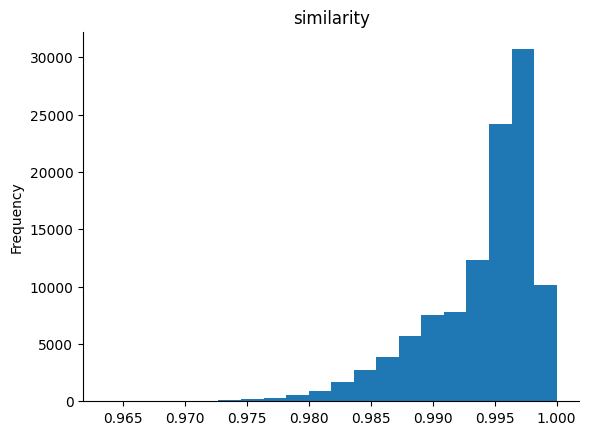

In [27]:
from matplotlib import pyplot as plt
df['similarity'].plot(kind='hist', bins=20, title='similarity')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [29]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

# Rebuild the model
def codebert_embedding_model():
    input_ids = tf.keras.layers.Input(shape=(512,), dtype='int32')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype='int32')
    embeddings = codebert_model(input_ids, attention_mask=attention_mask)[0][:,0,:]
    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=embeddings)

embedding_model = codebert_embedding_model()
embedding_model.load_weights("new_code_similarity_model")

# Tokenize and Embedding Generation Function
def tokenize_code(file_path, tokenizer):
    with open(file_path, 'r', encoding='utf-8') as file:
        code = file.read()
    inputs = tokenizer(code, return_tensors="tf", truncation=True, padding='max_length', max_length=512)
    return tf.squeeze(inputs['input_ids']), tf.squeeze(inputs['attention_mask'])

def generate_embedding(file_path, tokenizer, model):
    input_ids, attention_mask = tokenize_code(file_path, tokenizer)
    embedding = model([tf.expand_dims(input_ids, 0), tf.expand_dims(attention_mask, 0)])
    return embedding[0]

# Generate embeddings for all files
file_embeddings = {file: generate_embedding(file, tokenizer, embedding_model) for file in all_arrays}

# Custom Similarity Function
def custom_similarity(embedding1, embedding2):
    distance = tf.norm(embedding1 - embedding2)
    similarity = tf.exp(-distance)
    return similarity.numpy()

# Prepare pairs for comparison and calculate similarity
comparisons = []
for i in range(len(all_arrays)):
    for j in range(i+1, len(all_arrays)):
        file1, file2 = all_arrays[i], all_arrays[j]
        similarity_score = custom_similarity(file_embeddings[file1], file_embeddings[file2])
        comparisons.append([file1, file2, similarity_score])

# Create DataFrame
df = pd.DataFrame(comparisons, columns=['file1', 'file2', 'similarity'])

# Display or save the DataFrame
print(df.head())
# df.to_csv('file_similarity_scores.csv', index=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


                                               file1  \
0  /content/Code_Similarity/Dataset Triploss/case...   
1  /content/Code_Similarity/Dataset Triploss/case...   
2  /content/Code_Similarity/Dataset Triploss/case...   
3  /content/Code_Similarity/Dataset Triploss/case...   
4  /content/Code_Similarity/Dataset Triploss/case...   

                                               file2  similarity  
0  /content/Code_Similarity/Dataset Triploss/case...    0.293390  
1  /content/Code_Similarity/Dataset Triploss/case...    0.317644  
2  /content/Code_Similarity/Dataset Triploss/case...    0.351836  
3  /content/Code_Similarity/Dataset Triploss/case...    0.082933  
4  /content/Code_Similarity/Dataset Triploss/case...    0.357314  


In [37]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import AutoTokenizer

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

# Assuming the functions codebert_embedding_model, tokenize_code, and generate_embedding are defined as before

embedding_model = codebert_embedding_model()
embedding_model.load_weights("new_code_similarity_model")

# Generate embeddings for all files
file_embeddings = {file: generate_embedding(file, tokenizer, embedding_model) for file in all_arrays}

# Custom Similarity Function
def custom_similarity(embedding1, embedding2):
    distance = tf.norm(embedding1 - embedding2)
    similarity = tf.exp(-distance)
    return similarity.numpy()

# Define a threshold for similarity
similarity_threshold = 0.5  # You may need to adjust this value

# Prepare pairs for comparison, calculate similarity, and label
comparisons = []
for i in range(len(all_arrays)):
    for j in range(i+1, len(all_arrays)):
        file1, file2 = all_arrays[i], all_arrays[j]
        similarity_score = custom_similarity(file_embeddings[file1], file_embeddings[file2])
        label = "yes" if similarity_score >= similarity_threshold else "no"
        comparisons.append([file1, file2, similarity_score, label])

# Create DataFrame
df = pd.DataFrame(comparisons, columns=['file1', 'file2', 'similarity', 'label'])

# Display or save the DataFrame
print(df.head())
# df.to_csv('file_similarity_labels.csv', index=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


                                               file1  \
0  /content/Code_Similarity/Dataset Triploss/case...   
1  /content/Code_Similarity/Dataset Triploss/case...   
2  /content/Code_Similarity/Dataset Triploss/case...   
3  /content/Code_Similarity/Dataset Triploss/case...   
4  /content/Code_Similarity/Dataset Triploss/case...   

                                               file2  similarity label  
0  /content/Code_Similarity/Dataset Triploss/case...    0.293390    no  
1  /content/Code_Similarity/Dataset Triploss/case...    0.317644    no  
2  /content/Code_Similarity/Dataset Triploss/case...    0.351836    no  
3  /content/Code_Similarity/Dataset Triploss/case...    0.082933    no  
4  /content/Code_Similarity/Dataset Triploss/case...    0.357314    no  


In [38]:
df

,file1,file2,similarity,label
0,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.293390,no
1,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.317644,no
2,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.351836,no
3,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.082933,no
4,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.357314,no
...,...,...,...,...
108806,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.181195,no
108807,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.184345,no
108808,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.205148,no
108809,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.154153,no


from matplotlib import pyplot as plt
df['similarity'].plot(kind='hist', bins=20, title='similarity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['similarity'].plot(kind='line', figsize=(8, 4), title='similarity')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='similarity', y='label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


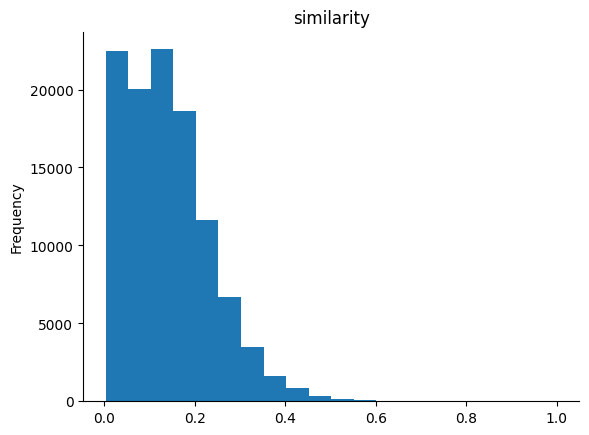

In [44]:
from matplotlib import pyplot as plt
df['similarity'].plot(kind='hist', bins=20, title='similarity')
plt.gca().spines[['top', 'right',]].set_visible(False)

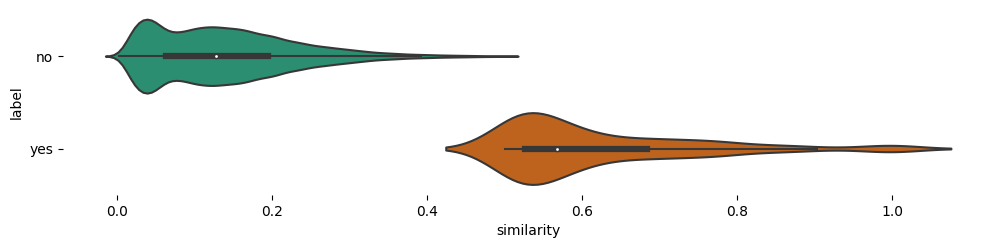

In [39]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='similarity', y='label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [41]:
df.head()

,file1,file2,similarity,label
0,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.293390,no
1,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.317644,no
2,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.351836,no
3,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.082933,no
4,/content/Code_Similarity/Dataset Triploss/case...,/content/Code_Similarity/Dataset Triploss/case...,0.357314,no


In [42]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense

# Assuming your DataFrame 'df' is already created and loaded

# Preparing the data
X = np.array(df['similarity']).reshape(-1, 1)  # Reshape for compatibility with GRU input
y = np.array(df['label'].apply(lambda x: 1 if x == 'yes' else 0))  # Convert labels to binary

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define GRU model
def build_model():
    input_layer = Input(shape=(1, 1))
    gru_layer = GRU(64, return_sequences=False)(input_layer)
    output_layer = Dense(1, activation='sigmoid')(gru_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
model.evaluate(X_test, y_test)


Epoch 1/10
2177/2177 [==============================] - 9s 3ms/step - loss: 0.0483 - accuracy: 0.9956 - val_loss: 0.0163 - val_accuracy: 0.9959
Epoch 2/10
2177/2177 [==============================] - 6s 3ms/step - loss: 0.0076 - accuracy: 0.9973 - val_loss: 0.0044 - val_accuracy: 0.9986
Epoch 3/10
2177/2177 [==============================] - 6s 3ms/step - loss: 0.0028 - accuracy: 0.9990 - val_loss: 0.0025 - val_accuracy: 0.9990
Epoch 4/10
2177/2177 [==============================] - 6s 3ms/step - loss: 0.0019 - accuracy: 0.9993 - val_loss: 0.0018 - val_accuracy: 0.9998
Epoch 5/10
2177/2177 [==============================] - 6s 3ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0014 - val_accuracy: 0.9999
Epoch 6/10
2177/2177 [==============================] - 6s 3ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0015 - val_accuracy: 0.9992
Epoch 7/10
2177/2177 [==============================] - 6s 3ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0012 - val_accuracy:

[0.0006510558887384832, 0.9998621344566345]

In [43]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense
import numpy as np

# Assuming your DataFrame 'df' is already created and loaded

# Prepare the data
X = np.array(df['similarity']).reshape(-1, 1)  # Reshape for compatibility with GRU input
y = np.array(df['label'].apply(lambda x: 1 if x == 'yes' else 0))  # Convert labels to binary

# Define K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # Example with 5 folds

# Function to build model (as before)
def build_model():
    input_layer = Input(shape=(1, 1))
    gru_layer = GRU(64, return_sequences=False)(input_layer)
    output_layer = Dense(1, activation='sigmoid')(gru_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Cross-validation scores
cv_scores = []

for train, test in kfold.split(X, y):
    # Create model
    model = build_model()

    # Train model
    model.fit(X[train], y[train], epochs=10, batch_size=32, verbose=0)  # Set verbose to 0 to reduce log output

    # Evaluate the model
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f"Score for fold: {scores}")
    cv_scores.append(scores[1])  # Assuming 1 is the index for accuracy

# Average performance across all folds
average_performance = np.mean(cv_scores)
print(f"Average Accuracy: {average_performance}")


Score for fold: [0.0005210708477534354, 0.9999080896377563]
Score for fold: [0.000729331630282104, 0.9995864629745483]
Score for fold: [0.0005557019612751901, 0.9998621344566345]
Score for fold: [0.0009587842505425215, 0.9994485974311829]
Score for fold: [0.0015663972590118647, 0.9991269111633301]
Average Accuracy: 0.9995864391326904


In [48]:
# prompt: downoload folder from google collab this /content/Code_Similarity

!zip -r Code_Similarity.zip /content/Code_Similarity


  adding: content/Code_Similarity/ (stored 0%)
  adding: content/Code_Similarity/TripletLoss.py (deflated 64%)
  adding: content/Code_Similarity/file_similarity_scores.csv (deflated 94%)
  adding: content/Code_Similarity/new_code_similarity_model/ (stored 0%)
  adding: content/Code_Similarity/new_code_similarity_model/saved_model.pb (deflated 92%)
  adding: content/Code_Similarity/new_code_similarity_model/variables/ (stored 0%)
  adding: content/Code_Similarity/new_code_similarity_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/Code_Similarity/new_code_similarity_model/variables/variables.index (deflated 77%)
  adding: content/Code_Similarity/new_code_similarity_model/keras_metadata.pb (deflated 96%)
  adding: content/Code_Similarity/new_code_similarity_model/assets/ (stored 0%)
  adding: content/Code_Similarity/new_code_similarity_model/fingerprint.pb (stored 0%)
  adding: content/Code_Similarity/Dataset Triploss/ (stored 0%)
  adding: content/Code_Simil